
# Generalized Frangi with Multi-modal Fusion for Crack Extraction, tested on FIND benchmark

This Colab notebook demonstrates the complete pipeline (download, unzip, Hessians, fusion, Frangi graph, HDBSCAN, MST + k-centers, animation, and metrics).


In [1]:
# Install deps
!pip -q install numpy scipy scikit-image matplotlib joblib tqdm tqdm-joblib hdbscan networkx gdown pot imageio pandas Pillow tqdm_joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.0 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Ludwig-H/Generalized-Frangi-for-Automatic-Crack-Extraction

Cloning into 'Generalized-Frangi-for-Automatic-Crack-Extraction'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 46 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (46/46), 30.56 KiB | 977.00 KiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
import os, sys, glob, re, random, numpy as np, imageio, matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed

# Allow importing from this repo if running in Colab after uploading or mounting
repo_path = os.path.abspath("Generalized-Frangi-for-Automatic-Crack-Extraction")
src_path = os.path.join(repo_path, "src")
if src_path not in sys.path:
    sys.path.append(src_path)


from frangi_fusion import (set_seed, auto_discover_find_structure, load_modalities_and_gt_by_index,
                           to_gray, compute_hessians_per_scale, fuse_hessians_per_scale,
                           build_frangi_similarity_graph, distances_from_similarity, triangle_connectivity_graph,
                           largest_connected_component, hdbscan_from_sparse,
                           mst_on_cluster, kcenters_on_tree, fault_graph_from_mst_and_kcenters,
                           skeletonize_lee, jaccard_index, tversky_index, wasserstein_distance_skeletons, thicken,
                           overlay_hessian_orientation, show_clusters_on_image, animate_fault_growth)

/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1) Download FIND `data.zip` and unzip

In [4]:

import gdown, zipfile
url = "https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK"
zip_path = "data.zip"
if not os.path.exists(zip_path):
    gdown.download(url, zip_path, quiet=False)

extract_dir = "data_find"
os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(extract_dir)
print("Unzipped to:", extract_dir)


Downloading...
From (original): https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK
From (redirected): https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK&confirm=t&uuid=fcd10f96-a94b-4290-862e-1be957d7a274
To: /content/data.zip
100%|██████████| 1.15G/1.15G [00:17<00:00, 66.7MB/s]


Unzipped to: data_find


## 2) Pick one image and display modalities

In [5]:
# --- FIX for FIND fused TIFFs and robust grayscale conversion ---

%pip -q install tifffile imageio scikit-image

import numpy as np, re, random
import imageio.v2 as iio
from skimage.io import imread as ski_imread
from importlib import reload
import sys, os

# ensure your src/ is on path if you import from the repo
if "src" not in "".join(sys.path):
    sys.path.append("/content/icpr2026-frangi-fusion-find/src")  # ajuste selon ton arbo

# ---------- robust readers / grayscale ----------
def _read_image_any(path):
    # 1) PIL
    try:
        from PIL import Image
        with Image.open(path) as im:
            arr = np.array(im)
            if arr.ndim == 3 and arr.shape[2] == 4:
                arr = arr[..., :3]
            return arr
    except Exception:
        pass
    # 2) imageio
    try:
        arr = iio.imread(path)
        if arr.ndim == 3 and arr.shape[2] == 4:
            arr = arr[..., :3]
        return arr
    except Exception:
        pass
    # 3) skimage (tifffile backend)
    try:
        arr = ski_imread(path)
        if arr.ndim == 3 and arr.shape[2] == 4:
            arr = arr[..., :3]
        return arr
    except Exception as e:
        raise e

def to_gray_uint8(img):
    # Accept HxW or HxWxC (any C>=1). For C>=3 use luminance on first 3, C==2 average.
    if img.ndim == 2:
        g = img.astype(np.float32)
    elif img.ndim == 3:
        c = img.shape[2]
        arr = img.astype(np.float32)
        if c >= 3:
            w = np.array([0.2989, 0.5870, 0.1140], dtype=np.float32)
            g = arr[..., :3].dot(w)
        elif c == 2:
            g = arr.mean(axis=2)
        else:  # C==1 or weird
            g = arr[..., 0]
    else:
        raise ValueError("Unsupported image shape")
    g -= g.min()
    if g.max() > 0:
        g /= g.max()
    return (g * 255).clip(0,255).astype(np.uint8)

# ---------- monkey-patch repo utilities if present ----------
try:
    import frangi_fusion.utils as U
    import frangi_fusion.hessian as H
    # patch readers / grayscale
    U._read_image = _read_image_any
    U.to_gray_uint8 = to_gray_uint8

    def _to_gray_float01(img):
        g = to_gray_uint8(img).astype(np.float32) / 255.0
        return g
    H.to_gray = _to_gray_float01
    reload(U); reload(H)
except Exception as _e:
    print("Patch local only (no package found). Proceeding with helper fns in notebook.")

# ---------- optional: safer loader that skips broken modalities ----------
import os, glob

def _is_image_file(p):
    return p.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff","bmp"))

def _extract_key(p):
    m = re.findall(r"\d+", os.path.basename(p))
    return m[-1] if m else os.path.basename(p)

def auto_discover_find_structure(root):
    all_imgs = [p for p in glob.glob(os.path.join(root, '**', '*.*'), recursive=True) if _is_image_file(p)]
    buckets = {'intensity': [], 'range': [], 'fused': [], 'label': []}
    for p in all_imgs:
        low = p.lower().replace('\\','/')
        if any(k in low for k in ['label','labels','gt','groundtruth','ground_truth','mask']):
            buckets['label'].append(p)
        elif any(k in low for k in ['fused','fusion']):
            buckets['fused'].append(p)
        elif any(k in low for k in ['range','depth']):
            buckets['range'].append(p)
        elif any(k in low for k in ['intensity','gray','grayscale']):
            buckets['intensity'].append(p)
        else:
            buckets['intensity'].append(p)
    for k in buckets: buckets[k] = sorted(buckets[k])
    return buckets

def load_modalities_and_gt_by_index(struct, index):
    base_list = struct['label'] if struct['label'] else struct['intensity']
    assert base_list, "No images found in FIND root."
    index = index % len(base_list)
    key = _extract_key(base_list[index])
    out = {'paths':{}, 'arrays':{}}
    for k in ['intensity','range','fused','label']:
        cand = [p for p in struct.get(k,[]) if _extract_key(p)==key]
        if not cand:
            continue
        pth = cand[0]
        try:
            arr = _read_image_any(pth)
            out['paths'][k] = pth
            if k == 'label':
                g = to_gray_uint8(arr)
                out['arrays'][k] = (g > 127).astype(np.uint8) * 255
            else:
                out['arrays'][k] = to_gray_uint8(arr)
        except Exception as e:
            # skip unreadable modality
            print(f"[WARN] Skipping unreadable {k}: {pth} ({e})")
            continue
    return out


Selected index: 428
intensity -> data_find/data/img/filtered/im00429.png
range -> data_find/data/img/range/im00429.png
fused -> data_find/data/img/fused/im00429.tif


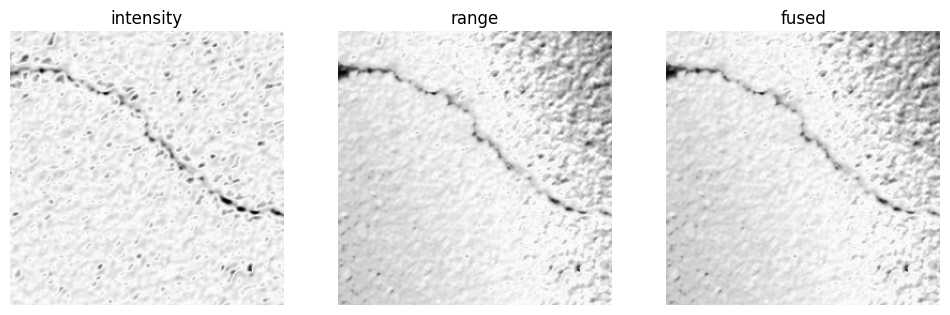

In [6]:

set_seed(123)
struct = auto_discover_find_structure(extract_dir)
n_total = len(struct["label"]) if struct["label"] else len(struct["intensity"])
index = random.randint(0, max(0,n_total-1))
dat = load_modalities_and_gt_by_index(struct, index)
print("Selected index:", index)
for k,v in dat["paths"].items():
    print(k, "->", v)

cols = len(dat["arrays"])
plt.figure(figsize=(4*cols,4))
for i,(k,arr) in enumerate(dat["arrays"].items()):
    plt.subplot(1, cols, i+1); plt.title(k); plt.imshow(arr, cmap='gray'); plt.axis('off')
plt.show()


## 3) Parameters

In [7]:

sigmas = [3]
beta = 0.5
c = 0.25
ctheta = 0.125
R = 3
K = 1
expZ = 2.0


## 4–5) Hessians and fusion

In [8]:
mods = {}
if "intensity" in dat["arrays"]:
    mods["intensity"] = compute_hessians_per_scale(to_gray(dat["arrays"]["intensity"]), sigmas)
if "range" in dat["arrays"]:
    mods["range"] = compute_hessians_per_scale(to_gray(dat["arrays"]["range"]), sigmas)
# if "fused" in dat["arrays"]:
#     mods["fused"] = compute_hessians_per_scale(to_gray(dat["arrays"]["fused"]), sigmas)

weights = {k:1/len(mods.keys()) for k in mods.keys()}
fused_H = fuse_hessians_per_scale(mods, weights)
print("Fused using modalities:", list(mods.keys()))


Fused using modalities: ['intensity', 'range']


## 6) Visualize Hessian overlays

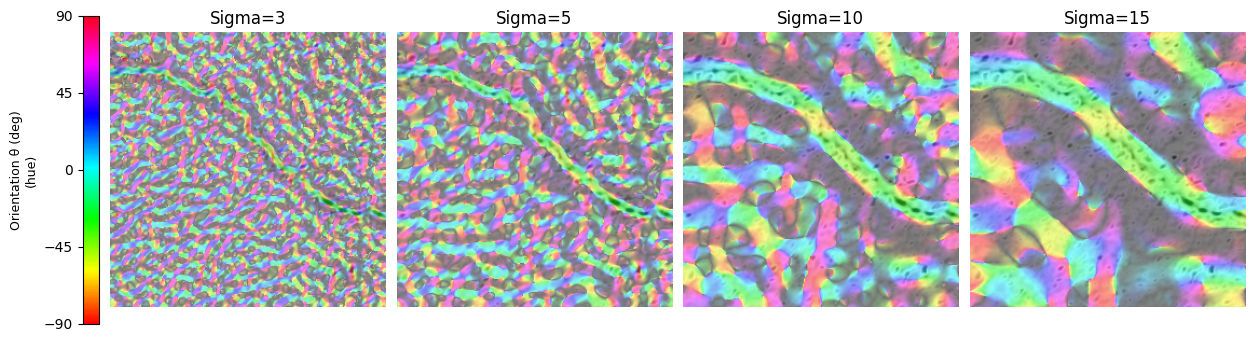

In [9]:

# base = dat["arrays"].get("intensity", list(dat["arrays"].values())[0])
# plt.figure(figsize=(15,4))
# for i, Hd in enumerate(fused_H[:4]):
#     overlay = overlay_hessian_orientation(base, Hd, alpha=0.5)
#     plt.subplot(1,4,i+1); plt.title(f"Sigma={Hd['sigma']}"); plt.imshow(overlay); plt.axis('off')
# plt.show()

# Overlays avec une seule échelle (orientation) à gauche
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

base = dat["arrays"].get("intensity", list(dat["arrays"].values())[0])

fig = plt.figure(figsize=(15,4))
# 1 colonne étroite pour la légende + 4 colonnes pour les images
gs = fig.add_gridspec(nrows=1, ncols=5, width_ratios=[0.06, 1, 1, 1, 1], wspace=0.05)

# Barre de couleur pour l'orientation θ (en degrés), mappée sur HSV
cax = fig.add_subplot(gs[0, 0])
sm = mpl.cm.ScalarMappable(cmap=mpl.cm.hsv,
                           norm=mpl.colors.Normalize(vmin=-90, vmax=90))
cb = fig.colorbar(sm, cax=cax)
cb.set_label("Orientation θ (deg)\n(hue)", fontsize=9)
cb.set_ticks([-90, -45, 0, 45, 90])
cax.yaxis.tick_left()
cax.yaxis.set_label_position('left')

# Affiche les 4 premières échelles
for i, Hd in enumerate(fused_H[:4]):
    ax = fig.add_subplot(gs[0, i+1])
    overlay = overlay_hessian_orientation(base, Hd, alpha=0.5)
    ax.imshow(overlay)
    ax.set_title(f"Sigma={Hd['sigma']}")
    ax.axis('off')

plt.show()


## 7–8) Frangi graph and optional triangle-connectivity

In [10]:

coords, neighbors, S = build_frangi_similarity_graph(fused_H, beta, c, ctheta, R)
D = distances_from_similarity(S)
if K==2:
    D = triangle_connectivity_graph(coords, D)
print("Graph nodes:", D.shape[0], "non-zeros:", D.nnz)


Graph nodes: 49307 non-zeros: 1246124


## 9) Largest connected component

In [11]:

D_cc, idx_nodes = largest_connected_component(D)
print("Largest CC nodes:", D_cc.shape[0])
sub_coords = coords[idx_nodes]


Largest CC nodes: 48642


## 10–11) HDBSCAN and cluster display

Clusters: [0]


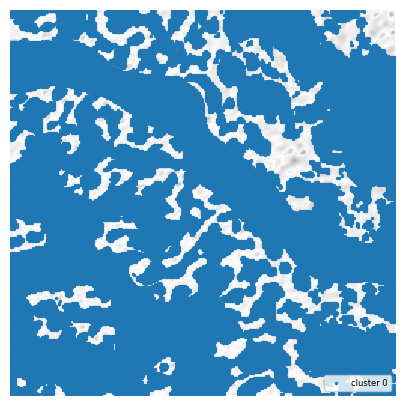

In [17]:
from scipy.sparse import csr_matrix
import sys

# # Increase recursion depth limit to handle potentially deep cluster trees
# sys.setrecursionlimit(10000)

D_cc64 = D_cc.astype(np.float64, copy=False)

labels = hdbscan_from_sparse(
    D_cc64,
    min_cluster_size=200,
    min_samples=1,
    allow_single_cluster=True,
    expZ=1.0
)
print("Clusters:", np.unique(labels))
show_clusters_on_image(base, sub_coords, labels, figsize=(5,5))


# labels = hdbscan_from_sparse(D_cc, min_cluster_size=50, min_samples=5, allow_single_cluster=True, expZ=2.0)

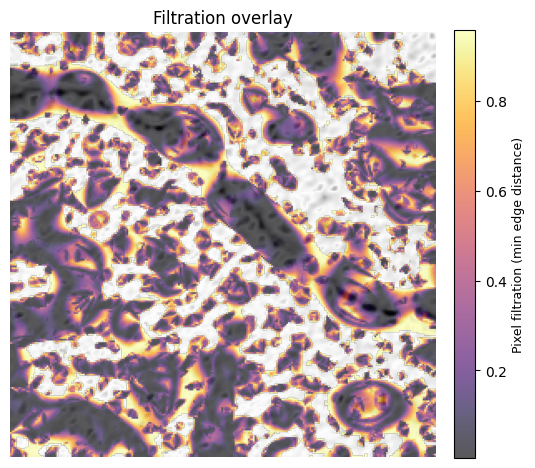

In [19]:
# Filtration per pixel = min neighbor distance; overlay on image
import numpy as np
import matplotlib.pyplot as plt

n = D_cc.shape[0]
indptr, indices, data = D_cc.indptr, D_cc.indices, D_cc.data

filtration = np.full(n, np.inf, dtype=np.float64)
for i in range(n):
    row_vals = data[indptr[i]:indptr[i+1]]
    if row_vals.size > 0:
        filtration[i] = float(row_vals.min())

# map to image grid (NaN for non-candidate pixels)
fmap = np.full(base.shape[:2], np.nan, dtype=np.float32)
rr, cc = sub_coords[:,0], sub_coords[:,1]
fmap[rr, cc] = filtration.astype(np.float32)

# robust display range
vmin = np.nanpercentile(fmap, 5)
vmax = np.nanpercentile(fmap, 95)
masked = np.ma.masked_invalid(fmap)

plt.figure(figsize=(6,6))
plt.imshow(base, cmap='gray')
im = plt.imshow(masked, cmap='inferno', alpha=0.65, vmin=vmin, vmax=vmax)
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.set_label("Pixel filtration (min edge distance)", fontsize=9)
plt.axis('off')
plt.title("Filtration overlay")
plt.show()


## 12) MST + k-centers -> fault graph

In [13]:

fault_edges_list = []
for lab in np.unique(labels):
    if lab < 0:
        continue
    cluster_idx = np.where(labels==lab)[0]
    if cluster_idx.size < 3:
        continue
    mst = mst_on_cluster(D_cc, cluster_idx)
    k = max(3, int(cluster_idx.size/100))
    centers = kcenters_on_tree(mst, k, objective="max")
    Gf = fault_graph_from_mst_and_kcenters(mst, centers, weight_agg="mean")
    rows, cols = Gf.nonzero()
    for i,j in zip(rows, cols):
        if i<j:
            w = float(Gf[i,j])
            r0,c0 = sub_coords[i]
            r1,c1 = sub_coords[j]
            fault_edges_list.append([int(r0),int(c0),int(r1),int(c1),w])
fault_edges = np.array(fault_edges_list, dtype=np.float32) if len(fault_edges_list)>0 else np.zeros((0,5),dtype=np.float32)
print("Fault edges:", fault_edges.shape)


Fault edges: (172, 5)


In [18]:
fault_edges

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.47000000e+02,
        5.72513714e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.14000000e+02,
        4.61381003e-02],
       [0.00000000e+00, 1.47000000e+02, 0.00000000e+00, 2.14000000e+02,
        7.58527443e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.26000000e+02,
        3.04063167e-02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 2.00000000e+01,
        1.91601645e-02],
       [0.00000000e+00, 1.26000000e+02, 1.00000000e+00, 2.00000000e+01,
        1.46477735e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.60000000e+01,
        1.84307575e-01],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.90000000e+01,
        1.86694741e-01],
       [0.00000000e+00, 3.60000000e+01, 1.00000000e+00, 1.90000000e+01,
        2.29207784e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.20000000e+01,
        1.14263117e-01],
       [0.00000000e+00, 0.0000

## 13) Animation

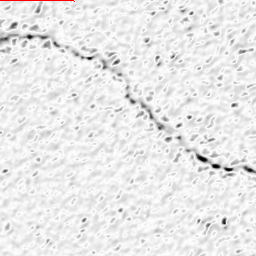

In [14]:

anim_path = "fault_growth.gif"
if fault_edges.shape[0] > 0:
    animate_fault_growth(dat['arrays']['intensity'], fault_edges, anim_path, steps=25)
    from IPython.display import Image, display
    display(Image(filename=anim_path))
else:
    print("No fault edges to animate.")


## 14) Threshold at τ = 0.3

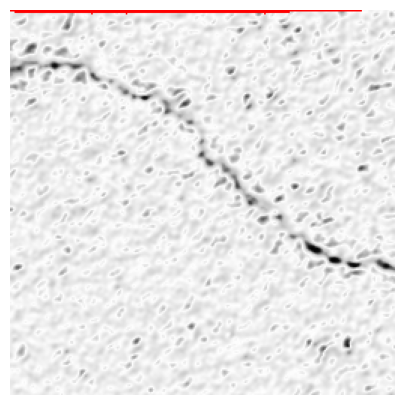

In [15]:

tau = 0.3
img = dat['arrays']['intensity']
overlay = np.dstack([img,img,img]).astype(np.float32)
H, W = img.shape[:2]
thr_edges = fault_edges[fault_edges[:,-1] <= tau]
for e in thr_edges:
    r0,c0,r1,c1,w = e
    rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
    cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
    rr = np.clip(rr, 0, H-1); cc = np.clip(cc, 0, W-1)
    overlay[rr,cc,0] = 255; overlay[rr,cc,1] = 0; overlay[rr,cc,2] = 0
plt.figure(figsize=(5,5)); plt.imshow(overlay.astype(np.uint8)); plt.axis('off'); plt.show()


## 15) Metrics vs GT (Lee skeleton)

Jaccard: 0.0 Tversky: 0.0 Wasserstein: 1666.0


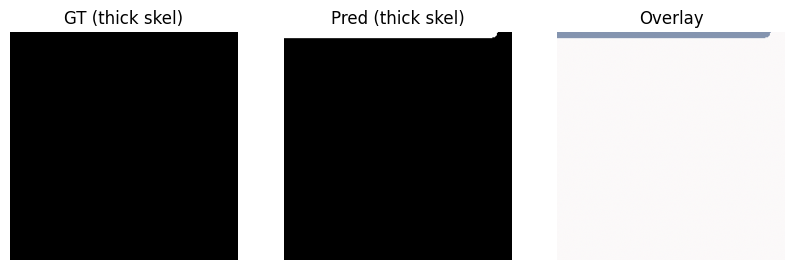

In [16]:

mask = np.zeros_like(img, dtype=np.uint8)
for e in thr_edges:
    r0,c0,r1,c1,w = e
    rr = np.linspace(r0, r1, num=int(max(abs(r1-r0),abs(c1-c0))+1)).astype(int)
    cc = np.linspace(c0, c1, num=rr.shape[0]).astype(int)
    rr = np.clip(rr, 0, img.shape[0]-1); cc = np.clip(cc, 0, img.shape[1]-1)
    mask[rr,cc] = 1

sk_pred = skeletonize_lee(mask>0)
sk_pred = thicken(sk_pred, pixels=6)
gt = (dat["arrays"].get("label", np.zeros_like(img)) > 0).astype(np.uint8)
sk_gt = skeletonize_lee(gt); sk_gt = thicken(sk_gt, pixels=6)
jac = jaccard_index(sk_pred, sk_gt)
tvs = tversky_index(sk_pred, sk_gt, alpha=1.0, beta=0.5)
wass = wasserstein_distance_skeletons(sk_pred, sk_gt)
print("Jaccard:", jac, "Tversky:", tvs, "Wasserstein:", wass)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title("GT (thick skel)"); plt.imshow(sk_gt, cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("Pred (thick skel)"); plt.imshow(sk_pred, cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(sk_gt*255, cmap='Reds', alpha=0.7); plt.imshow(sk_pred*255, cmap='Blues', alpha=0.5); plt.axis('off')
plt.show()
